In [1]:
import tensorflow as tf
import pathlib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
from sklearn.model_selection import train_test_split
from tensorflow.keras import activations
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, SeparableConv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation, Add

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
country_images_root = pathlib.Path("/home/pascal_steiger/Downloads/data7/")

In [4]:
def load_image_paths(container_path):
    image_dir = pathlib.Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "A image classification dataset"
    image_paths = []
    flat_data = []
    target = []
    count = 0
    train_img_path = []
    train_label = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            count += 1
            train_img_path.append(str(file))
            train_label.append(categories[i])

    X = np.array(train_img_path)
    y = np.array(train_label)
    catStringArr = np.array(categories)

    return X, y, catStringArr

In [5]:
X = []
y = []
X, y, labelStringArr = load_image_paths("/home/pascal_steiger/Downloads/data7/")
img_df = pd.DataFrame(zip(X, y), columns=["path", "label"])

img_df.sample(n=10)

,path,label
3383,/home/pascal_steiger/Downloads/data7/GBR/img_5...,GBR
5597,/home/pascal_steiger/Downloads/data7/PRT/img_P...,PRT
2134,/home/pascal_steiger/Downloads/data7/ITA/img_I...,ITA
1361,/home/pascal_steiger/Downloads/data7/ISL/img_I...,ISL
4667,/home/pascal_steiger/Downloads/data7/FIN/img_F...,FIN
6063,/home/pascal_steiger/Downloads/data7/CHE/img_4...,CHE
1928,/home/pascal_steiger/Downloads/data7/ISL/img_I...,ISL
5374,/home/pascal_steiger/Downloads/data7/PRT/img_P...,PRT
87,/home/pascal_steiger/Downloads/data7/MKD/img_M...,MKD
3210,/home/pascal_steiger/Downloads/data7/GBR/img_5...,GBR


In [42]:
train_df, test_df = train_test_split(img_df, shuffle=True, test_size=0.2, random_state=42)


print(train_df.sample(n=5))
print(train_df.shape)
print(test_df.sample(n=5))
print(test_df.shape)

                                                   path label
938   /home/pascal_steiger/Downloads/data7/MKD/img_M...   MKD
3391  /home/pascal_steiger/Downloads/data7/GBR/img_5...   GBR
309   /home/pascal_steiger/Downloads/data7/MKD/img_M...   MKD
5517  /home/pascal_steiger/Downloads/data7/PRT/img_P...   PRT
2871  /home/pascal_steiger/Downloads/data7/ITA/img_I...   ITA
(5611, 2)
                                                   path label
4453  /home/pascal_steiger/Downloads/data7/FIN/img_F...   FIN
6805  /home/pascal_steiger/Downloads/data7/CHE/img_4...   CHE
6552  /home/pascal_steiger/Downloads/data7/CHE/img_4...   CHE
4808  /home/pascal_steiger/Downloads/data7/FIN/img_F...   FIN
6081  /home/pascal_steiger/Downloads/data7/CHE/img_4...   CHE
(1403, 2)


In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [43]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col="path",
        y_col="label",
        target_size=(400, 450),
        batch_size=32,
        class_mode="sparse",
        seed=42
)


validation_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col="path",
        y_col="label",
        target_size=(400, 400),
        batch_size=32,
        class_mode="sparse",
        shuffle=False
)

Found 5611 validated image filenames belonging to 7 classes.
Found 1403 validated image filenames belonging to 7 classes.


In [9]:
I = Input(shape=(400,400,3), dtype="float32")

c2d1= Conv2D(32, (3, 3), (2, 2), activation="relu")(I)
b1 = BatchNormalization()(c2d1)
c2d2= Conv2D(64, (3, 3), activation="relu")(b1)
b2 = BatchNormalization()(c2d2)

c1d1= Conv2D(1, 1, (2, 2))(b2)
b3 = BatchNormalization()(c1d1)

sc2d1= SeparableConv2D(128, (3, 3), padding="same")(b2)
b4 = BatchNormalization()(sc2d1)
relu1= Activation(activations.relu)(b4)
sc2d2= SeparableConv2D(128, (3, 3), padding="same")(relu1)
b5 = BatchNormalization()(sc2d2)
mp1= MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(b5)

add1 = Add()([b3, mp1])

c1d2= Conv2D(1, 1, (2, 2))(add1)
b6 = BatchNormalization()(c1d2)

relu2= Activation(activations.relu)(add1)
sc2d3= SeparableConv2D(256, (3, 3), padding="same")(relu2)
b7 = BatchNormalization()(sc2d3)
relu3= Activation(activations.relu)(b7)
sc2d4= SeparableConv2D(256, (3, 3), padding="same")(relu3)
b8 = BatchNormalization()(sc2d4)
mp2= MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(b8)

add2 = Add()([b6, mp2])

c1d3= Conv2D(1, 1, (2, 2))(add2)
b9 = BatchNormalization()(c1d3)

relu4= Activation(activations.relu)(add2)
sc2d5= SeparableConv2D(728, (3, 3), padding="same")(relu4)
b10 = BatchNormalization()(sc2d5)
relu5= Activation(activations.relu)(b10)
sc2d6= SeparableConv2D(728, (3, 3), padding="same")(relu5)
b11 = BatchNormalization()(sc2d6)
mp3= MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(b11)

add3 = Add()([b9, mp3])

relu6= Activation(activations.relu)(add3)
sc2d7= SeparableConv2D(728, (3, 3), padding="same")(relu6)
b12 = BatchNormalization()(sc2d7)
relu7= Activation(activations.relu)(b12)
sc2d8= SeparableConv2D(728, (3, 3), padding="same")(relu7)
b13 = BatchNormalization()(sc2d8)

add4 = Add()([add3, b13])

relu8= Activation(activations.relu)(add4)
sc2d9= SeparableConv2D(728, (3, 3), padding="same")(relu8)
b14 = BatchNormalization()(sc2d9)
relu9= Activation(activations.relu)(b14)
sc2d10= SeparableConv2D(728, (3, 3), padding="same")(relu9)
b15 = BatchNormalization()(sc2d10)

add5 = Add()([add4, b15])

relu10= Activation(activations.relu)(add5)
sc2d11= SeparableConv2D(728, (3, 3), padding="same")(relu10)
b16 = BatchNormalization()(sc2d11)
relu11= Activation(activations.relu)(b16)
sc2d12= SeparableConv2D(728, (3, 3), padding="same")(relu11)
b17 = BatchNormalization()(sc2d12)

add6 = Add()([add5, b17])

relu12= Activation(activations.relu)(add6)
sc2d13= SeparableConv2D(728, (3, 3), padding="same")(relu12)
b18 = BatchNormalization()(sc2d13)
relu13= Activation(activations.relu)(b18)
sc2d14= SeparableConv2D(728, (3, 3), padding="same")(relu13)
b19 = BatchNormalization()(sc2d14)

add7 = Add()([add6, b19])

relu14= Activation(activations.relu)(add7)
sc2d15= SeparableConv2D(728, (3, 3), padding="same")(relu14)
b20 = BatchNormalization()(sc2d15)
relu15= Activation(activations.relu)(b20)
sc2d16= SeparableConv2D(728, (3, 3), padding="same")(relu15)
b21 = BatchNormalization()(sc2d16)

add8 = Add()([add7, b21])

c1d4= Conv2D(1, 1, (2, 2))(add8)
b21 = BatchNormalization()(c1d4)

relu16= Activation(activations.relu)(add8)
sc2d17= SeparableConv2D(728, (3, 3), padding="same")(relu16)
b22 = BatchNormalization()(sc2d17)
relu17= Activation(activations.relu)(b22)
sc2d18= SeparableConv2D(1024, (3, 3), padding="same")(relu17)
b23 = BatchNormalization()(sc2d18)
mp9= MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(b23)

add9 = Add()([b21, mp9])

sc2d19= SeparableConv2D(1536, (3, 3), activation="relu")(add9)
b24 = BatchNormalization()(sc2d19)
sc2d20= SeparableConv2D(2048, (3, 3), activation="relu")(b24)
b25 = BatchNormalization()(sc2d20)

gap = GlobalAveragePooling2D()(b25)

flat = Flatten()(gap)
dense = Dense(1024, activation='relu')(flat)
dropout = Dropout(0.3)(dense)
dense2 = Dense(512, activation='relu')(dropout)
dropout2 = Dropout(0.1)(dense2)
dense3 = Dense(7, activation='softmax')(dropout2)

model = tf.keras.Model(I, dense3)

In [10]:
early_stopping = EarlyStopping(
    monitor='val_sparse_categorical_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_sparse_categorical_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [11]:
with tf.device("/device:GPU:0"):
    model.compile(optimizer = tf.optimizers.Nadam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [12]:
with tf.device("/device:GPU:0"):
    history = model.fit(train_generator,
      #steps_per_epoch=2000 // 32,  
      epochs=100,
      verbose=1,
      validation_data = validation_generator,
      callbacks = callbacks)

Epoch 1/100
176/176 [==============================] - 303s 2s/step - loss: 1.7932 - sparse_categorical_accuracy: 0.2871 - val_loss: 1.9743 - val_sparse_categorical_accuracy: 0.1504
Epoch 2/100
176/176 [==============================] - 282s 2s/step - loss: 1.4980 - sparse_categorical_accuracy: 0.4283 - val_loss: 2.1838 - val_sparse_categorical_accuracy: 0.1447
Epoch 3/100
176/176 [==============================] - 281s 2s/step - loss: 1.3684 - sparse_categorical_accuracy: 0.4896 - val_loss: 2.1988 - val_sparse_categorical_accuracy: 0.2495
Epoch 4/100
176/176 [==============================] - 283s 2s/step - loss: 1.2759 - sparse_categorical_accuracy: 0.5224 - val_loss: 2.5473 - val_sparse_categorical_accuracy: 0.3664
Epoch 5/100
176/176 [==============================] - 281s 2s/step - loss: 1.2210 - sparse_categorical_accuracy: 0.5489 - val_loss: 3.4368 - val_sparse_categorical_accuracy: 0.2381
Epoch 6/100
176/176 [==============================] - 281s 2s/step - loss: 1.1512 - spars

Epoch 45/100
176/176 [==============================] - 281s 2s/step - loss: 0.2179 - sparse_categorical_accuracy: 0.9196 - val_loss: 0.8992 - val_sparse_categorical_accuracy: 0.7434
Epoch 46/100
176/176 [==============================] - 280s 2s/step - loss: 0.2071 - sparse_categorical_accuracy: 0.9259 - val_loss: 0.9213 - val_sparse_categorical_accuracy: 0.7562
Epoch 47/100
176/176 [==============================] - 282s 2s/step - loss: 0.2226 - sparse_categorical_accuracy: 0.9173 - val_loss: 0.8165 - val_sparse_categorical_accuracy: 0.7940
Epoch 48/100
176/176 [==============================] - 282s 2s/step - loss: 0.2038 - sparse_categorical_accuracy: 0.9273 - val_loss: 1.0634 - val_sparse_categorical_accuracy: 0.7156
Epoch 49/100
176/176 [==============================] - 283s 2s/step - loss: 0.1876 - sparse_categorical_accuracy: 0.9353 - val_loss: 0.8422 - val_sparse_categorical_accuracy: 0.7705
Epoch 50/100
176/176 [==============================] - 283s 2s/step - loss: 0.1924 -

176/176 [==============================] - 281s 2s/step - loss: 0.0426 - sparse_categorical_accuracy: 0.9847 - val_loss: 1.0333 - val_sparse_categorical_accuracy: 0.8090
Epoch 89/100
176/176 [==============================] - 281s 2s/step - loss: 0.0380 - sparse_categorical_accuracy: 0.9884 - val_loss: 1.0639 - val_sparse_categorical_accuracy: 0.8033
Epoch 90/100
176/176 [==============================] - 281s 2s/step - loss: 0.0392 - sparse_categorical_accuracy: 0.9879 - val_loss: 1.0463 - val_sparse_categorical_accuracy: 0.8104

Epoch 00090: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 91/100
176/176 [==============================] - 280s 2s/step - loss: 0.0343 - sparse_categorical_accuracy: 0.9906 - val_loss: 1.0489 - val_sparse_categorical_accuracy: 0.8061
Epoch 92/100
176/176 [==============================] - 282s 2s/step - loss: 0.0344 - sparse_categorical_accuracy: 0.9891 - val_loss: 1.0602 - val_sparse_categorical_accuracy: 0.8047
Epoch 93/100
176

In [13]:
with tf.device("/device:GPU:0"):
    model.save('CNN_v5_fullNet-data7.h5')

/home/pascal_steiger/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


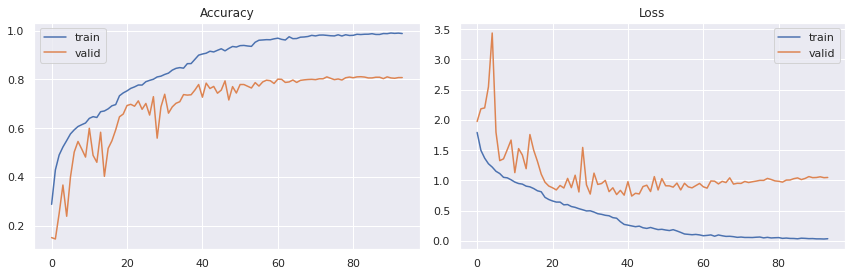

In [14]:
# plot training and validation metrics

sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['sparse_categorical_accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_sparse_categorical_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('CNN(400,400)_v5-data7.png')

plt.show()

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
num_of_test_samples=1403
batch_size=32

Y_pred = model.predict(validation_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
target_names = sorted(labelStringArr)


print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[178   0   2   1   4   6   1]
 [  4 166  10   3   6   1   8]
 [  6   3 140   2  24   8  12]
 [  3   2   5 198   2   2   3]
 [  3   2  19   2 120  15  28]
 [  3   0   3   0  14 176   7]
 [  2   1  10   0  30   8 160]]
Classification Report
              precision    recall  f1-score   support

         CHE       0.89      0.93      0.91       192
         FIN       0.95      0.84      0.89       198
         GBR       0.74      0.72      0.73       195
         ISL       0.96      0.92      0.94       215
         ITA       0.60      0.63      0.62       189
         MKD       0.81      0.87      0.84       203
         PRT       0.73      0.76      0.74       211

    accuracy                           0.81      1403
   macro avg       0.81      0.81      0.81      1403
weighted avg       0.82      0.81      0.81      1403



In [37]:
print(validation_generator.class_indices.keys())
print(np.argmax(Y_pred[0]))
print(y_pred)

dict_keys(['CHE', 'FIN', 'GBR', 'ISL', 'ITA', 'MKD', 'PRT'])
2
[2 1 5 ... 5 0 6]


In [27]:
print(labelStringArr)
print(sorted(labelStringArr))

['MKD' 'ISL' 'ITA' 'GBR' 'FIN' 'PRT' 'CHE']
['CHE', 'FIN', 'GBR', 'ISL', 'ITA', 'MKD', 'PRT']
